# Import Packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score

from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction import DictVectorizer

from sklearn.decomposition import PCA

import seaborn as sns

# Clean Data

In [18]:
#read data
data = pd.read_csv('hotel_bookings.csv')

#drop NaNs
data2 = data.drop(labels=['company', 'reservation_status', 'reservation_status_date'], axis=1)
data2 = data2[data2['meal'] != "Undefined" ]
data2= data2[data2['distribution_channel'] != 'Undefined']
data2= data2[data2['distribution_channel'] != 'Undefined']
data2= data2[data2['agent'].notna()]

#convert categoricals to numericals
data_categorical_expanded = pd.get_dummies(data2)
labels= data_categorical_expanded['is_canceled']
data_categorical_expanded=data_categorical_expanded.drop(labels=['is_canceled'], axis=1)

In [19]:
data_categorical_expanded

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
3,13,2015,27,1,0,1,1,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,14,2015,27,1,0,2,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,14,2015,27,1,0,2,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
7,9,2015,27,1,0,2,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,85,2015,27,1,0,3,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,35,30,2,5,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
119386,102,2017,35,31,2,5,3,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
119387,34,2017,35,31,2,5,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
119388,109,2017,35,31,2,5,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0


# Dimensionality Reduction

In [20]:
pca = PCA(n_components = 10)
pca = pca.fit(data_categorical_expanded)

In [21]:
# plt.bar(x = pca.get_feature_names_out(),height = pca.explained_variance_)
# plt.show()

We will choose to reduce the dimensionality of the data to 6 features becausing the explained variance reduces to practically 0 after the 6th feature.

In [22]:
X_pca = PCA(n_components = 6).fit_transform(data_categorical_expanded)
X_pca.shape

(102217, 6)

# Feature Selection

In [23]:
MI = SelectKBest(score_func = mutual_info_classif, k = 25)
MI = MI.fit(data_categorical_expanded, labels)

selected_features = list(MI.get_feature_names_out())
scores = list(MI.scores_[MI.get_support()])

signif_vars_df = pd.DataFrame({'selected features':selected_features,
              'mutual info':scores}).sort_values(by = ['mutual info'], ascending = False)
signif_vars_df

,selected features,mutual info
21,deposit_type_No Deposit,0.135297
22,deposit_type_Non Refund,0.123461
5,agent,0.085719
7,adr,0.082528
0,lead_time,0.075608
14,country_PRT,0.071368
3,previous_cancellations,0.048758
9,total_of_special_requests,0.047712
8,required_car_parking_spaces,0.027801
19,assigned_room_type_A,0.024976


Text(0.5, 1.0, 'Correlation Matrix Spearman Method- Categorical Data ')

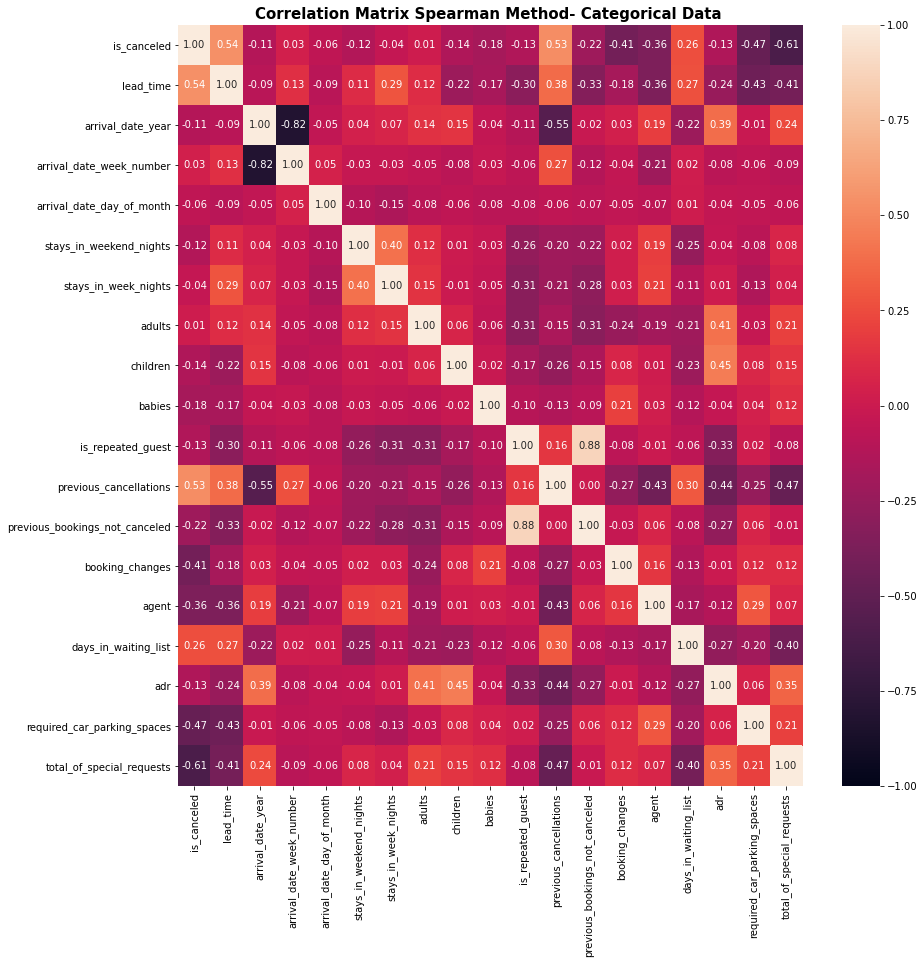

In [24]:
# Plot correlation matrix of features to see heat map of correlations to pick best features
plt.figure(figsize=(14,14))
df_corr = data2.corr(method='spearman')
heatmap = sns.heatmap(df_corr.corr(), fmt=".2f", vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix Spearman Method- Categorical Data ",size=15, weight='bold')

In [25]:
df_corr = data2.corr(method = 'spearman')["is_canceled"]
df_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.291497
previous_cancellations            0.290095
total_of_special_requests         0.286335
required_car_parking_spaces       0.189748
booking_changes                   0.171239
agent                             0.112290
days_in_waiting_list              0.102904
previous_bookings_not_canceled    0.076452
adults                            0.038286
babies                            0.033886
is_repeated_guest                 0.030812
stays_in_weekend_nights           0.027341
adr                               0.017852
stays_in_week_nights              0.014266
arrival_date_day_of_month         0.005935
arrival_date_week_number          0.005913
arrival_date_year                 0.004861
children                          0.002886
Name: is_canceled, dtype: float64

# Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split (
    
    data_categorical_expanded.filter(selected_features),
    labels,
    test_size=0.2,
    random_state = 42
)

X_train_pca, X_test_pca, y_train, y_test = train_test_split (
    
    X_pca,
    labels,
    test_size=0.2,
    random_state = 42
)

# Scaled Data

In [27]:
def scale_data(X):
    scaler = StandardScaler()
    scaler.fit(X)
    
    return pd.DataFrame(data = scaler.transform(X),
             columns = X.columns)

X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

# Logistic Regression

0.7763647035805126


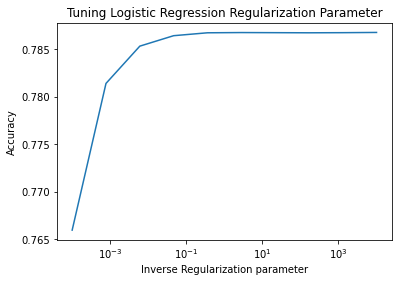

In [28]:
#train model
LR = LogisticRegressionCV(Cs = 10, cv = 5, penalty = 'l2',
                          scoring = 'accuracy', solver = 'saga',
                          tol = 1e-2, max_iter = 100,
                          multi_class = 'ovr', random_state = 42,
                          n_jobs = 8
                    ).fit(X_train_scaled, y_train)

print(LR.score(X_test_scaled,y_test))

plt.plot(LR.Cs_,np.mean(LR.scores_[1], axis = 0))
plt.semilogx()
plt.ylabel('Accuracy')
plt.title('Tuning Logistic Regression Regularization Parameter')
plt.xlabel('Inverse Regularization parameter')
plt.show()

In [29]:
regres_coefs_df = pd.DataFrame({'var name':list(LR.feature_names_in_),
              'regression coef':list(LR.coef_[0]),
            'odds ratio': np.exp(LR.coef_[0])
            }).sort_values(by = ['odds ratio'], ascending = False)
regres_coefs_df

,var name,regression coef,odds ratio
3,previous_cancellations,1.164428,3.204089
22,deposit_type_Non Refund,0.812090,2.252611
19,assigned_room_type_A,0.795896,2.216426
23,customer_type_Transient,0.654628,1.924426
14,country_PRT,0.617601,1.854473
0,lead_time,0.500693,1.649864
7,adr,0.349827,1.418822
1,stays_in_week_nights,0.108671,1.114795
10,hotel_City Hotel,0.067129,1.069433
2,adults,0.059925,1.061757


In [30]:
LR = LogisticRegressionCV(Cs = 10, cv = 5, penalty = 'l2',
                          scoring = 'accuracy', solver = 'saga',
                          tol = 1e-2, max_iter = 100,
                          multi_class = 'ovr', random_state = 42,
                          n_jobs = 8)


LR_scaled = LR.fit(X_train_scaled, y_train)
LR_scaled_score = LR_scaled.score(X_test_scaled,y_test)

LR_normal = LR.fit(X_train, y_train)
LR_normal_score = LR_normal.score(X_test,y_test)

LR_pca = LR.fit(X_train_pca, y_train)
LR_pca_score = LR_pca.score(X_test_pca,y_test)

print(LR_normal_score,LR_scaled_score,LR_pca_score)

0.7649677166894933 0.7763647035805126 0.6445900997847779


# Random Forest

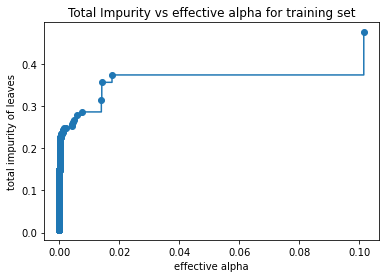

In [31]:

clf = DecisionTreeClassifier(random_state = 0)

#determine regularization parameter, α, of decision tree
path = clf.cost_complexity_pruning_path(X_train_scaled,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(1,1)
ax.plot(ccp_alphas[:], impurities[:], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()


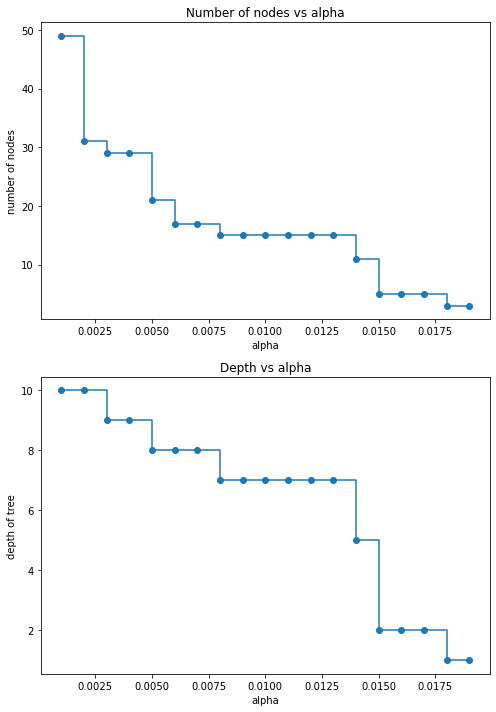

In [32]:
ccp_alphas = np.linspace(.001,.02,20)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_scaled,y_train)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,10))
ax[0].plot(ccp_alphas, node_counts, marker="o",drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

Random Forest Accuracy with 10 trees: 0.8455292506358834
Random Forest Accuracy with 25 trees: 0.8542359616513402
Random Forest Accuracy with 50 trees: 0.8565349246722754
Random Forest Accuracy with 75 trees: 0.8575621209156721
Random Forest Accuracy with 100 trees: 0.8570240657405596


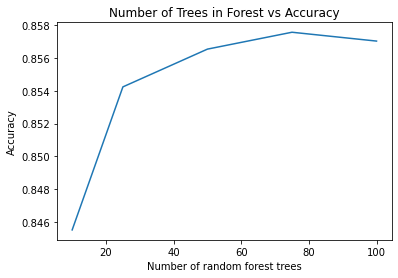

In [33]:
scores=[]
vals= [10,25,50,75,100]

warnings.simplefilter('ignore') #ignore warning output at each iteration

for i in vals:
    rdm = RandomForestClassifier(n_estimators = int(i),
                                 criterion = 'gini',
                                       min_samples_leaf = 1,
                                       bootstrap = True,
                                       oob_score = True,
                                       random_state = 0,
                                     ccp_alpha = 0.000,
                                       max_samples = None,
                                n_jobs = 8,
                                warm_start = True)
    
    rdm = rdm.fit(X_train_scaled, y_train)
    pred = rdm.predict(X_test_scaled)
    scorest = accuracy_score(pred,y_test)
    scores.append(scorest)
    print(f"Random Forest Accuracy with {i} trees: {scorest}")

plt.plot(vals,scores)
plt.xlabel('Number of random forest trees')
plt.title("Number of Trees in Forest vs Accuracy")
plt.ylabel('Accuracy')
plt.show()

#-------------------------------------------------------------


In [34]:
rdm = RandomForestClassifier(n_estimators = 75,
                                 criterion = 'gini',
                                       min_samples_leaf = 1,
                                       bootstrap = True,
                                       oob_score = True,
                                       random_state = 0,
                                     ccp_alpha = 0.000,
                                       max_samples = None,
                                n_jobs = 8,
#                                 warm_start = True
                            )

rdm_scaled = rdm.fit(X_train_scaled, y_train)
pred = rdm.predict(X_test_scaled)
rdm_scaled_score = accuracy_score(pred,y_test)

rdm_normal = rdm.fit(X_train, y_train)
pred = rdm.predict(X_test)
rdm_normal_score = accuracy_score(pred,y_test)

rdm_pca = rdm.fit(X_train_pca, y_train)
pred = rdm.predict(X_test_pca)
rdm_pca_score = accuracy_score(pred,y_test)

# K Nearest Neigbors

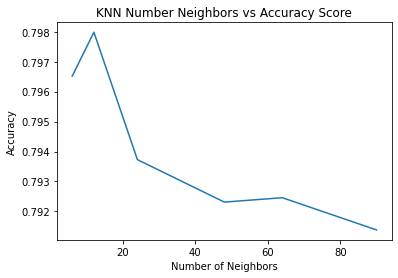

In [35]:
knn_accuracies = []
n_neighbors = [6,12,24,48,64,90]
for i in n_neighbors:
    
    #train
    knn = KNeighborsClassifier(n_neighbors= i, weights = 'distance', n_jobs = 8)
    knn = knn.fit(X_train,y_train)
    
    #test
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    
    #record
    knn_accuracies.append(accuracy)
    
#plot 
plt.plot(n_neighbors,knn_accuracies)
plt.xlabel('Number of Neighbors')
plt.title('KNN Number Neighbors vs Accuracy Score')
plt.ylabel('Accuracy')
plt.show()




In [36]:
knn = KNeighborsClassifier(n_neighbors = 12, weights = 'distance', n_jobs = 8)
knn= knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)
knn_score_scaled = accuracy_score(y_test,y_pred)

knn = KNeighborsClassifier(n_neighbors = 12, weights = 'distance', n_jobs = 8)
knn= knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn_score = accuracy_score(y_test,y_pred)

knn = KNeighborsClassifier(n_neighbors = 12, weights = 'distance', n_jobs = 8)
knn= knn.fit(X_train_pca,y_train)
y_pred = knn.predict(X_test_pca)
knn_score_pca = accuracy_score(y_test,y_pred)

print("scores:",knn_score,knn_score_scaled,knn_score_pca)

scores: 0.7979847387986695 0.836284484445314 0.791234592056349


# Gaussian Mixture Model

In [37]:
model = GaussianMixture(n_components = 2,random_state=42).fit(X_train)
predictions = model.predict(X_test)
gmm_score = accuracy_score(y_test, predictions)

model = GaussianMixture(n_components = 2,random_state=42).fit(X_train_scaled)
predictions = model.predict(X_test_scaled)
gmm_score_scaled = accuracy_score(y_test, predictions)

model = GaussianMixture(n_components = 2,random_state=42).fit(X_train_pca)
predictions = model.predict(X_test_pca)
gmm_score_pca = accuracy_score(y_test, predictions)

print("scores:",gmm_score,gmm_score_scaled,gmm_score_pca)

scores: 0.7375269027587557 0.2994032478966934 0.6173938563881823


# Comparing Results

In [38]:
data = {'Logistic Regression':[LR_pca_score,LR_normal_score,LR_scaled_score] ,
        'Gaussian Mixture Model': [gmm_score_pca,gmm_score,gmm_score_scaled],
        'K Nearest Neighbors':[knn_score_pca,knn_score,knn_score_scaled],
        'Random Forest':[rdm_pca_score,rdm_normal_score,rdm_scaled_score]}

cols = ['K = 6 PCA','K = 25 Top Features','w/ Scaling',]
pd.DataFrame(data = data, index = cols).transpose()

,K = 6 PCA,K = 25 Top Features,w/ Scaling
Logistic Regression,0.644590,0.764968,0.776365
Gaussian Mixture Model,0.617394,0.737527,0.299403
K Nearest Neighbors,0.791235,0.797985,0.836284
Random Forest,0.801604,0.870965,0.857562
